**CSC466 Final Project Report**

One model is trained using the Labeled Faces in the Wild dataset produced by UMass Amherst. We wanted to train a model and identify ways on how we can improve accuracy. We also predicted the LFW dataset on two pretrained models to compare performance and identify biases.

**Facial Recognition Library Model**

This model was trained on the Labeled Faces in the Wild dataset with the help of the Face Recognition libarary and the implementation of the Histogram of Oriented Gradients (HOG) algorithm. The dataset contained 13,233 images of 5,749 unique people with 1,680 people having more than one photo. Subjects who had only one photo were removed from the dataset to avoid imbalance. 

For the first round of evaluation, the model was trained on images of people who had more than one photo in the LFW datset. This means that the model was trained on atleast one image per subject and tested on one image per subject. This resulted in an accuracy score of 25.10%.

We wanted to find out how we can improve the accuracy score, so we decided to eliminate the subjects with only two images in the LFW dataset. This means that in the second round, the model was trained on atleast two images per subject and tested on one image per subject. This resulted in an accuracy score of 48.89%.

Both learning curves for round one and round two show that both models perform really well on the training set, however there is overfitting pattern due to the low validation scores seen when the training size is lower. It does, however, performs better and better as the training size increases. Looking at the two learning curves, it can also be inferred that training on more images per person is results in bettet model performance because of the higher intercept. Compared to round one, the intercept for the validation score for round two starts at above 0.1. Essentially, the model will perform better as the training size increases, but having more images per person helps the model achieve a higher validation score at a lower training size. Thus, subjects having many different images can provide more variation for the model to learn effectively which improves the rate of correct classification of subjects.


In [1]:
from pathlib import Path
import pickle
import face_recognition
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Define paths
DEFAULT_ENCODINGS_PATH = Path("/Users/kkragas/Desktop/CSC 466/466_MOdel1/encodings.pkl")
IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}

In [3]:
# train data
def encode_known_faces(encodings_location: Path = DEFAULT_ENCODINGS_PATH):
    # stores labeled images and their encodings
    labels = []
    encodings = []

    # iterate over files in the subdirectories of the training directory
    for filepath in Path(training).glob("*/*"):
        # extracts the name of current subdirectory that is being iterated
        if filepath.suffix.lower() in IMAGE_EXTENSIONS:
            # extracts the name of current subdirectory that is being iterated
            label = filepath.parent.name
            image = face_recognition.load_image_file(filepath)
            face_locations = face_recognition.face_locations(image, model="hog")
            # transalate each detected face into encodings
            face_encodings = face_recognition.face_encodings(image, face_locations)

            for encoding in face_encodings:
                labels.append(label)
                encodings.append(encoding)

    labeled_encodings = {"labels": labels, "encodings": encodings}
    with encodings_location.open(mode="wb") as f:
        pickle.dump(labeled_encodings, f)

In [4]:
# classify faces
def recognize_faces(image_location: str, encodings_location: Path = DEFAULT_ENCODINGS_PATH):
    # open and load the saved encodings using pickle
    with encodings_location.open(mode="rb") as f:
        loaded_encodings = pickle.load(f)
    
    # load in unlabeled image you want to classify
    unlabelled_image = face_recognition.load_image_file(image_location)
    input_face_locations = face_recognition.face_locations(unlabelled_image, model="hog")
    input_face_encodings = face_recognition.face_encodings(unlabelled_image, input_face_locations)

    #iterate through each pair of face location and encoding  at the same time
    for face_location, unknown_encoding in zip(input_face_locations, input_face_encodings):
        # identify the face using helper function
        label = _recognize_face(unknown_encoding, loaded_encodings)
        # if face is not recognized, identity is unknown
        if not label:
            label = "Unknown"

        return(label)
    
def _recognize_face(unknown_encoding, loaded_encodings):
    # compare unlabeled encoding with the labeled encodings -> boolean value of whether each unknown encoding matches known
    # unknown: [36t4] known: [457q, 877a, 36t4, a123] bool_matches: [FALSE, FALSE, TRUE, FALSE]
    boolean_matches = face_recognition.compare_faces(loaded_encodings["encodings"], unknown_encoding)
    # pairs each boolean match with the corresponding label then counts the number of matches
    votes = Counter(label for match, label in zip(boolean_matches, loaded_encodings["labels"]) if match)
    # return most commonly occuring label
    if votes:
        return votes.most_common(1)[0][0]


In [5]:
# predict using the validation set
def validate(validationFile: str):
    actual_labels = []
    predicted_labels = []
    for filepath in Path(validationFile).rglob("*"):
        if filepath.is_file() and filepath.suffix.lower() in IMAGE_EXTENSIONS:
            # label = name of file
            actual = filepath.stem
            predicted = recognize_faces(image_location=str(filepath.absolute()))

            if predicted is None:
               predicted = "Unknown"

            actual_labels.append(actual)
            predicted_labels.append(predicted)

    #print(actual_labels)
    #print(predicted_labels)
    
    return actual_labels, predicted_labels

In [6]:
def plot_learning_curve(title, estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")

    plt.legend(loc="best")
    plt.show()

Accuracy: 0.2510410469958358


/Users/kkragas/Desktop/CSC 466/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


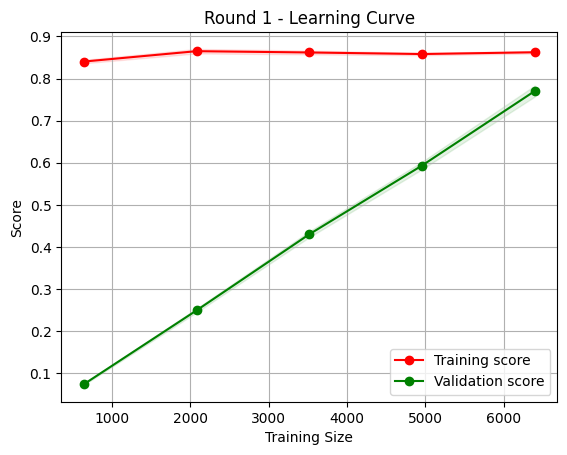

In [7]:
####################### Round 1 #######################
# define paths
training = Path("/Users/kkragas/Desktop/CSC 466/466_MOdel1/training1")
# train
encode_known_faces()
# test
a, p = validate("/Users/kkragas/Desktop/CSC 466/466_MOdel1/testing1")
# metrics
accuracy = accuracy_score(a, p)
print(f"Accuracy: {accuracy}")
#learning curve
with DEFAULT_ENCODINGS_PATH.open(mode="rb") as f:
    labeled_encodings = pickle.load(f)

X = np.array(labeled_encodings["encodings"])
y = np.array(labeled_encodings["labels"])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

estimator = KNeighborsClassifier(n_neighbors=3)
title = "Round 1 - Learning Curve"
plot_learning_curve(title, estimator, X, y_encoded)


Accuracy: 0.48891352549889133


/Users/kkragas/Desktop/CSC 466/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


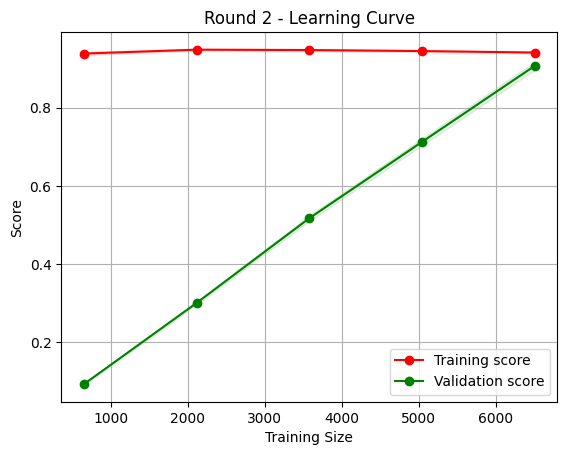

In [8]:
####################### Round 2  #######################
# define paths
training = Path("/Users/kkragas/Desktop/CSC 466/466_MOdel1/training2")
# train
encode_known_faces()
# test
a, p = validate("/Users/kkragas/Desktop/CSC 466/466_MOdel1/testing2")
# metrics
accuracy = accuracy_score(a, p)
print(f"Accuracy: {accuracy}")
#learning curve
with DEFAULT_ENCODINGS_PATH.open(mode="rb") as f:
    labeled_encodings = pickle.load(f)

X = np.array(labeled_encodings["encodings"])
y = np.array(labeled_encodings["labels"])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

estimator = KNeighborsClassifier(n_neighbors=3)
title = "Round 2 - Learning Curve"
plot_learning_curve(title, estimator, X, y_encoded)

**DeepFace Library Model**

This model was the one that performed the worst. Our theory is that it was not suited to the style of photo that was present in the dataset, which were frequently off-center, non-forward facing, or had multiple people in the frame. Additionally, for some photos the model couldn't even recognize that there was a face present in the image at all. The model we used was created in 2015 and its poor accuracy could be attributed to its age.

For this model, we used the `pairs.csv` file, which is a list of pairs of photos for people with more than one photo in the dataset. We read in the data and removed any rows containing two different people. Then, we fed each pair to the model and asked it to verify whether the two photos were of the same person.  

If it wrongly declared two photos as not of the same person, the person's name was added to the list of misidentified people. This would allow us to go back through the people later on to see if there were any trends within the misidentified people.


**Results matrix:**

`[2285, 3415]` [correct, incorrect]

The file of people that were misidentified can be found in `deepFaceMisidentified.csv`. Some people who had more than 2 photos appeared in the `pairs.csv` file more than once, so they were checked more times. If they were misidentified more than once, they will appear in the .csv file several times.
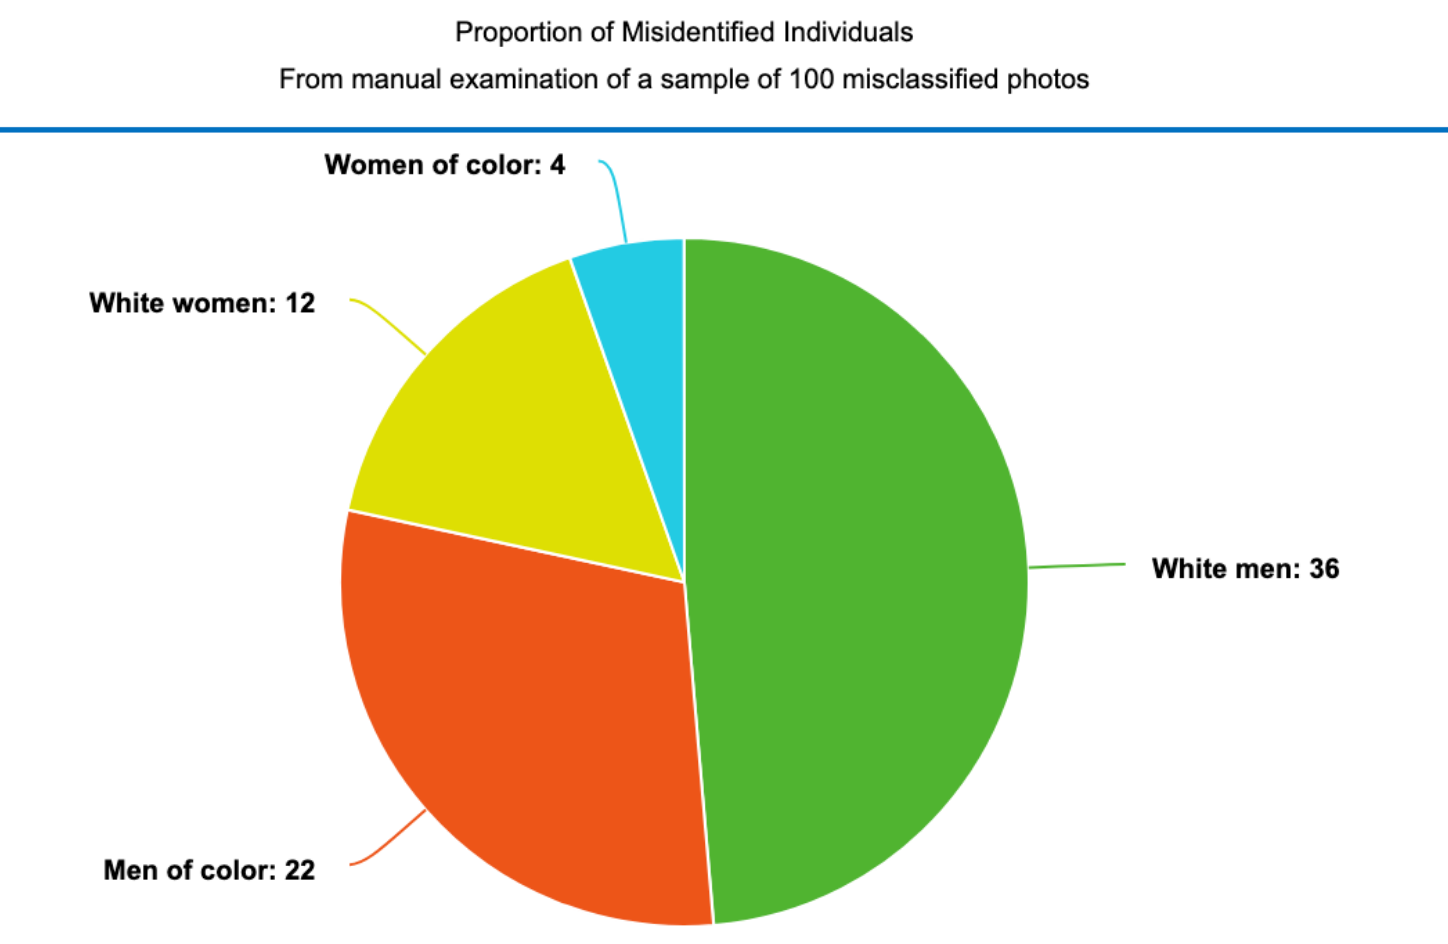

In [ ]:
from deepface import DeepFace
import cv2
import matplotlib.pyplot as plt


def verify(pairSet):
    # Initialize a dictionary to keep track of model scores
    model = "VGG-Face"      # The DeepFace library has a variety of models. We chose to use VGG-Face
    model_score = [0, 0]
    misclassified_faces = []

    # Check each pair against each model
    for pair in pairSet:
        # Establish the folder and two images to look at
        path = "archive/lfw-deepfunneled/lfw-deepfunneled/" + pair[0] + "/"
        img1_path = path + pair[1] + ".jpg"
        img2_path = path + pair[2] + ".jpg"
        try:
            res = DeepFace.verify(img1_path, img2_path, model_name = model)
            if res['verified']:
                model_score[0] += 1
            else:
                model_score[1] += 1
                misclassified_faces.append(pair[0])
        # Some faces cannot be identified as a face by the model
        except Exception:
            model_score[1] += 1
            misclassified_faces.append(pair[0])

    # Display the number of correctly and incorrectly classified faces, as well as who was misclassified
    print(model_score)
    print(misclassified_faces)


def getPeople():
    # Open and read the file
    pairs = open("archive/pairs.csv", "r")
    pairs = pairs.read().splitlines()

    # Extract the pairs and transform to file stubs
    pairs = [pair.split(",")[:3] for pair in pairs][1:5701]
    pairs = [[pair[0], pair[0] + "_" + pair[1].zfill(4), pair[0] + "_" + pair[2].zfill(4)] for pair in pairs]

    return pairs


verify(getPeople())

**FaceNet Library Model**

This model performed the best to identify the same person given multiple pictures of themselves. We think it is because of the MTCNN (the Multi-task cascaded Convolutional Networks) which is a tool that was used for face detection and alignment, ensuring that the faces are correctly cropped and aligned prior to embedding calculation. The other models did not have that thus it could have led to inaccurate fitting/recognition of images that would've been recognized if they were pre-processed with the MTCNN.

For this model, we used the training folder from the original dataset that contained a folder with thousands of other folders each one with one or more photos of the same person. We used an algorithm shown below to create pairs of images from folders with greater than 1 and less than 12 photos of the same person (for time's sake). We fed the model each pair of 2 photos and the model would label if they were recognized as the same person or not.

If it wrongly declared two photos as not of the same person, the person's name was added to the list of misidentified people. This would allow us to go back through the people later on to see if there were any trends within the misidentified people.

Our results matrix was:  [5204, 496] [correct, incorrect]

After running, the model prints the location of the misidentified people and we manually looked up each name and noted which demographic they were a part of. This resulted in the following pie chart.


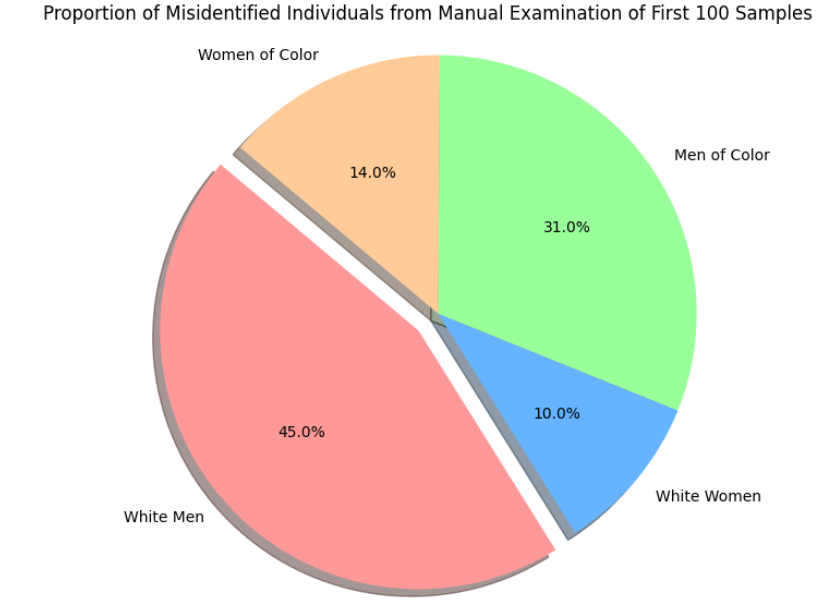

In [ ]:
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import os
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("verification.log"),
        logging.StreamHandler()
    ]
)

# Function to preprocess image and return the embeddings
def get_embedding(model, mtcnn, img_path):
    logging.info(f"Processing image: {img_path}")
    img = Image.open(img_path)
    img_cropped = mtcnn(img)
    if img_cropped is None:
        raise ValueError("Face not detected")
    with torch.no_grad():
        embedding = model(img_cropped.unsqueeze(0))
    return embedding

# Function to generate pairs of images from the training folder
def generate_pairs(training_dir):
    logging.info("Generating pairs from training directory")
    pairs = []
    for person_dir in os.listdir(training_dir):
        person_path = os.path.join(training_dir, person_dir)
        if os.path.isdir(person_path):
            images = [os.path.join(person_path, img) for img in os.listdir(person_path) if img.endswith('.jpg')]
            if 2 <= len(images) <= 11:
                for i in range(len(images)):
                    for j in range(i + 1, len(images)):
                        pairs.append((images[i], images[j]))
    logging.info(f"Generated {len(pairs)} pairs")
    return pairs

# Function to verify if two images are of the same person
def verify(pairs):
    logging.info("Starting verification process")
    model_score = [0, 0]
    misclassified_faces = []

    # Load the FaceNet model
    model = InceptionResnetV1(pretrained='vggface2').eval()
    mtcnn = MTCNN(image_size=160, margin=0)

    def process_pair(img1_path, img2_path):
        try:
            embedding1 = get_embedding(model, mtcnn, img1_path)
            embedding2 = get_embedding(model, mtcnn, img2_path)
            distance = torch.dist(embedding1, embedding2).item()
            threshold = 1.0
            if distance < threshold:
                logging.info(f"Match: {img1_path} and {img2_path}")
                return (True, img1_path, img2_path)
            else:
                logging.info(f"No Match: {img1_path} and {img2_path}")
                return (False, img1_path, img2_path)
        except Exception as e:
            logging.error(f"Error processing pair ({img1_path}, {img2_path}): {e}")
            return (False, img1_path, img2_path)

    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = [executor.submit(process_pair, img1, img2) for img1, img2 in pairs]
        for future in as_completed(futures):
            result, img1, img2 = future.result()
            if result:
                model_score[0] += 1
            else:
                model_score[1] += 1
                misclassified_faces.append((img1, img2))

    logging.info(f"Model Score: {model_score}")
    logging.info(f"Misclassified Faces: {misclassified_faces}")

# Set the directories relative to the project directory
training_dir = os.path.join(os.getcwd(), 'training')

logging.info("Script started")
pairs = generate_pairs(training_dir)
verify(pairs)
logging.info("Script finished")